# How to work with istSOS
## An example of basic data consistency checks

In the next cell we are going to:

* load the autoreload extension useful to keep update the external code library
* activated the autoreload
* activate the plot of graph directly inside jupyter

In [ ]:
!pip uninstall oatlib --yes
!pip uninstall matplotlib --yes
!pip install oatlib --no-cache
!pip install matplotlib --no-cache

In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

Now we load some libraries needed by this notebook

In [2]:
import requests
import json
from oatlib import sensor, method, oat_utils
from dateutil import parser
import matplotlib.pyplot as plt
from statistics import stdev


Set istSOS variables:

In [3]:
server = 'http://istsos.org/istsos'
service = 'demo'
user = None
pwd = None


List all the procedures

In [4]:
procedures = None

uri = '{}/wa/istsos/services/{}/procedures/operations/getlist'.format(
    server,
    service
)
try:
    if user and pwd:
        r = requests.get(uri, auth=(self.user, self.pwd))
    else:
        r = requests.get(uri)
    if r.status_code == 200:
        r_json = json.loads(r.text)
        procedures = r_json['data']
    else:
        print(r.status_code)
except Exception as e:
    raise e

The variable procedures is now a **LIST** of **DICTIONARIES**.
Each object contains the information of a procedure such as:
*sensortype, name, assignedid, offerings, id,
samplingTime, observedproperties, description.*

In [5]:
print(
    "Number of the procedures fetched: {}".format(
        len(procedures)
    )
)
print(
    "\nKeys for each procedure: {}".format(
        procedures[0].keys()
    )
)

print(
    '\nNames of the {} procedures fetched:'.format(
        len(procedures)
    )
)

for procedure in procedures:
    print(
        procedure['name']
    )

Number of the procedures fetched: 18

Keys for each procedure: dict_keys(['samplingTime', 'sensortype', 'observedproperties', 'description', 'name', 'assignedid', 'offerings', 'id'])

Names of the 18 procedures fetched:
arduino
BELLINZONA
GRABOW
LOCARNO2
P_ARDUINO
P_ARO
P_LUGANO
P_TRE
raspberry
RH_GNOSCA
T_ARDUINO
T_ARO
TEC_STATION
T_LUGANO
T_TRE
V_GNOSCA
V_GRABOW
V_LUGANO


Now we are going to choose one procedure from the list above
to retrieve the ***time_interval*** of the data and the observed properties

In [6]:
procedure_name = 'T_TRE'

procedure = list(
    filter(lambda x: x['name'] == procedure_name, procedures)
)[0]


time_interval = '{}/{}'.format(procedure['samplingTime']['beginposition'], procedure['samplingTime']['endposition'])

print(
    'Time interval: {}'.format(time_interval)
)

# the variable observed_properties is a list of dict
observed_properties = procedure['observedproperties']

print(
    '\nNumber of observed properties for the procedure {}: {}'.format(
        procedure_name,
        len(observed_properties)
    )
)

print(
    '\nList of the observed properties: {}'.format(observed_properties)
)




Time interval: 2018-03-01T00:10:00+0100/2018-09-01T02:00:00+0200

Number of observed properties for the procedure T_TRE: 1

List of the observed properties: [{'name': 'air-temperature', 'uom': '°C'}]


Load data from *istSOS* using *OAT*:

In [7]:
event_time = '2018-05-01T00:10:00+0100/2018-06-01T02:00:00+0200'

observed_property_name = observed_properties[0]['name']
observed_property_uom = observed_properties[0]['uom']

istsos_url = '{}/{}'.format(server, service)

basic_auth = (user, pwd)

SENSOR = sensor.Sensor(
    name=procedure_name,
    prop=observed_property_name,
    unit=observed_property_uom
)

SENSOR.ts_from_istsos(
    service=istsos_url,
    observed_property=':{}'.format(observed_property_name.replace('-',':')),
    procedure=procedure_name,
    basic_auth=basic_auth,
#     aggregate_function='AVG',
#     aggregate_interval='PT10M',
    event_time=event_time
)

SENSOR.save_to_csv(
    './output/{}.csv'.format(procedure_name)
)

print(SENSOR)

name: T_TRE
desc: None
lat: None
lon: None
alt: None
tz: +01:00
unit: b'\xc2\xb0C'
prop: air-temperature
freq: None
statflag: None
use: True
data_availability: ['2018-04-30T23:20:00', '2018-06-01T00:00:00']
ts:                             data  quality
time                                     
2018-05-01 00:20:00+01:00  12.70      400
2018-05-01 00:30:00+01:00  12.14      400
...                          ...      ...
2018-06-01 00:50:00+01:00  13.77      400
2018-06-01 01:00:00+01:00  13.84      400

[4469 rows x 2 columns]



/home/maxi/Documents/2019/didattica/PisaSummerSchool/OBS4RCH/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Plotting the TimeSeries

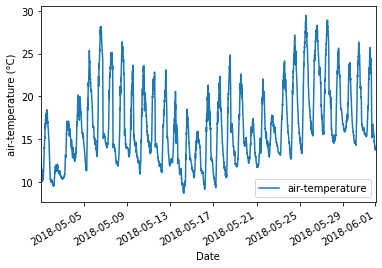

In [8]:

SENSOR.ts['data'].plot(legend=True, label=observed_property_name)
plt.ylabel('{} ({})'.format(observed_property_name, observed_property_uom))
plt.xlabel('Date')
plt.show()

## Quality check functions

[Click me](./qc_aws.pdf)

In [9]:
range_values = [-80, 60]

def plausible_value_check( x, range_values):
    if x >= range_values[0] and x <= range_values[1]:
        return 300
    else:
        return False

def time_consistency_check(x):
    if len(x) == 3:
        sum_abs_val = abs(x[1] - x[0]) + abs(x[1] - x[2])
        four_std = 4*stdev(x)
        if sum_abs_val <= four_std:
            return 400
        else:
            return False
    else:
        return False

try:
    ts_tmp = SENSOR.ts['data'].rolling(1).apply(lambda x: plausible_value_check(x, range_values), raw=True)
    SENSOR.ts['quality'].update(ts_tmp.where(lambda x : x>0))
    ts_tmp2 = SENSOR.ts['data'].rolling('1440s').apply(lambda x: time_consistency_check(x), raw=True)
    SENSOR.ts['quality'].update(ts_tmp2.where(lambda x : x>0))
    print("Data checked.")
except:
    print("Can't check data.")

Data checked.


Uploading data to istSOS.

In [10]:

oat_utils.sensors_to_istsos(
    service=istsos_url,
    procedure=procedure_name,
    obspro_sensor={'urn:ogc:def:parameter:x-istsos:1.0:meteo:air:temperature': SENSOR},
    how_merge='left'
)

print('Data loaded. Check istSOS.')

Data loaded. Check istSOS.


Filter values with QI == 400

In [11]:
SENSOR_400 = SENSOR.copy()
SENSOR_400.ts = SENSOR.ts[SENSOR.ts['quality'] == 400]

SENSOR_400.ts

data  quality
time                                     
2018-05-01 00:40:00+01:00  12.14      400
2018-05-01 00:50:00+01:00  12.32      400
...                          ...      ...
2018-06-01 00:50:00+01:00  13.77      400
2018-06-01 01:00:00+01:00  13.84      400

[4467 rows x 2 columns]

In [12]:
MAX_COL = 'T_MAX'
TIME_MAX_COL = 'TIME_' + MAX_COL
MIN_COL = 'T_MIN'
TIME_MIN_COL = 'TIME_' + MIN_COL
MEAN_COL = 'T_MEAN'
COUNT = '{}_COUNT'.format(MEAN_COL)



daily_max = oat_utils.sensorStats(
    SENSOR_400, stat='max',
    column_name=MAX_COL
)
daily_min = oat_utils.sensorStats(
    SENSOR_400, stat='min',
    column_name=MIN_COL
)
daily_mean = oat_utils.sensorStats(
    SENSOR_400, stat='mean',
    column_name=MEAN_COL
)

/home/maxi/Documents/2019/didattica/PisaSummerSchool/OBS4RCH/venv/lib/python3.6/site-packages/pandas/core/indexing.py:376: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  self.obj[key] = _infer_fill_value(value)
/home/maxi/Documents/2019/didattica/PisaSummerSchool/OBS4RCH/venv/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/maxi/Documents/2019/didat

In [13]:
daily_max

name: T_TRE
desc: None
lat: None
lon: None
alt: None
tz: +01:00
unit: b'\xc2\xb0C'
prop: air-temperature
freq: D
statflag: None
use: True
data_availability: ['2018-04-30T23:20:00', '2018-06-01T00:00:00']
ts:                            T_MAX quality                 TIME_T_MAX
2018-05-01 00:00:00+01:00  18.45     400  2018-05-01 13:20:00+01:00
2018-05-02 00:00:00+01:00  12.10     400  2018-05-02 12:20:00+01:00
...                          ...     ...                        ...
2018-05-31 00:00:00+01:00  25.73     400  2018-05-31 12:40:00+01:00
2018-06-01 00:00:00+01:00  14.09     400  2018-06-01 00:10:00+01:00

[32 rows x 3 columns]

In [14]:
daily_min

name: T_TRE
desc: None
lat: None
lon: None
alt: None
tz: +01:00
unit: b'\xc2\xb0C'
prop: air-temperature
freq: D
statflag: None
use: True
data_availability: ['2018-04-30T23:20:00', '2018-06-01T00:00:00']
ts:                            T_MIN quality                 TIME_T_MIN
2018-05-01 00:00:00+01:00  10.00     400  2018-05-01 22:30:00+01:00
2018-05-02 00:00:00+01:00   9.54     400  2018-05-02 04:40:00+01:00
...                          ...     ...                        ...
2018-05-31 00:00:00+01:00  13.77     400  2018-05-31 23:50:00+01:00
2018-06-01 00:00:00+01:00  13.77     400  2018-06-01 00:50:00+01:00

[32 rows x 3 columns]

In [15]:
daily_mean.ts['Completeness (%)'] = daily_mean.ts['T_MEAN_COUNT'] / 144*100

In [16]:
daily_mean

name: T_TRE
desc: None
lat: None
lon: None
alt: None
tz: +01:00
unit: b'\xc2\xb0C'
prop: air-temperature
freq: D
statflag: None
use: True
data_availability: ['2018-04-30T23:20:00', '2018-06-01T00:00:00']
ts:                               T_MEAN  T_MEAN_COUNT  Completeness (%)
time                                                                
2018-05-01 00:00:00+01:00  13.666071           140         97.222222
2018-05-02 00:00:00+01:00  10.837569           144        100.000000
...                              ...           ...               ...
2018-05-31 00:00:00+01:00  18.092222           144        100.000000
2018-06-01 00:00:00+01:00  13.962857             7          4.861111

[32 rows x 3 columns]

/home/maxi/Documents/2019/didattica/PisaSummerSchool/OBS4RCH/venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


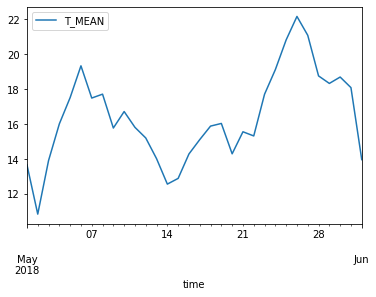

In [17]:
daily_mean.ts['T_MEAN'].plot(legend=True, label='T_MEAN')